# Intro to NLP using SciKit Learn and Python
### Can we predict the points range, price range and grape variety of a wine from a wine experts description?
A project to introduce you to a simple Bag of Words NLP using SciKit Learn and Python. You can use this same logic for document classification or any text classification problem you may be trying to solve.

HINT: Shift + Enter is the shortcut to run each cell

## Import packages and data
### 1. Import the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

### 2. We need data!
1. I used a dataset I found on Kaggle. Kaggle is an online community of data scientists. 
    * [Wine Dataset from Repo](https://raw.githubusercontent.com/cassieview/intro-nlp-wine-reviews/master/dataset/winemag-review.csv)
    * [Kaggle Dataset](https://www.kaggle.com/zynicide/wine-reviews)
3. Import the data as a [Pandas](https://pandas.pydata.org/pandas-docs/stable/) DataFrame

In [2]:
#File path to the csv file
csv_file = "https://raw.githubusercontent.com/cassieview/intro-nlp-wine-reviews/master/dataset/winemag-review.csv"

# Read csv file into dataframe
df = pd.read_csv(csv_file)

# Print first 5 rows in the dataframe
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Visualize the data
Once we have the data then its time to analyze it and do some [Feature Selection and Engineering](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/create-features?WT.mc_id=github-blog-casiljan). We will visualize our data using [Seaborn](https://seaborn.pydata.org/). This will allow us to see if there is a strong correlation between different data points and help us answer questions about our data. Since our initial question was around predicting `price`, `points` or `variety` from the `description` we already know that our Feature will be the `description` and our Label will be `price`, `points`or `variety`. Features are the data we use to make predictions and Labels are what we are predicting. Each label will be a separate model so there will be three models in total if you choose to build all three predictive models.

For fun, lets ask some questions about the data and answer them by graphing it with Seaborn.

### 3. Lets look at a WordCloud of the `description` Text

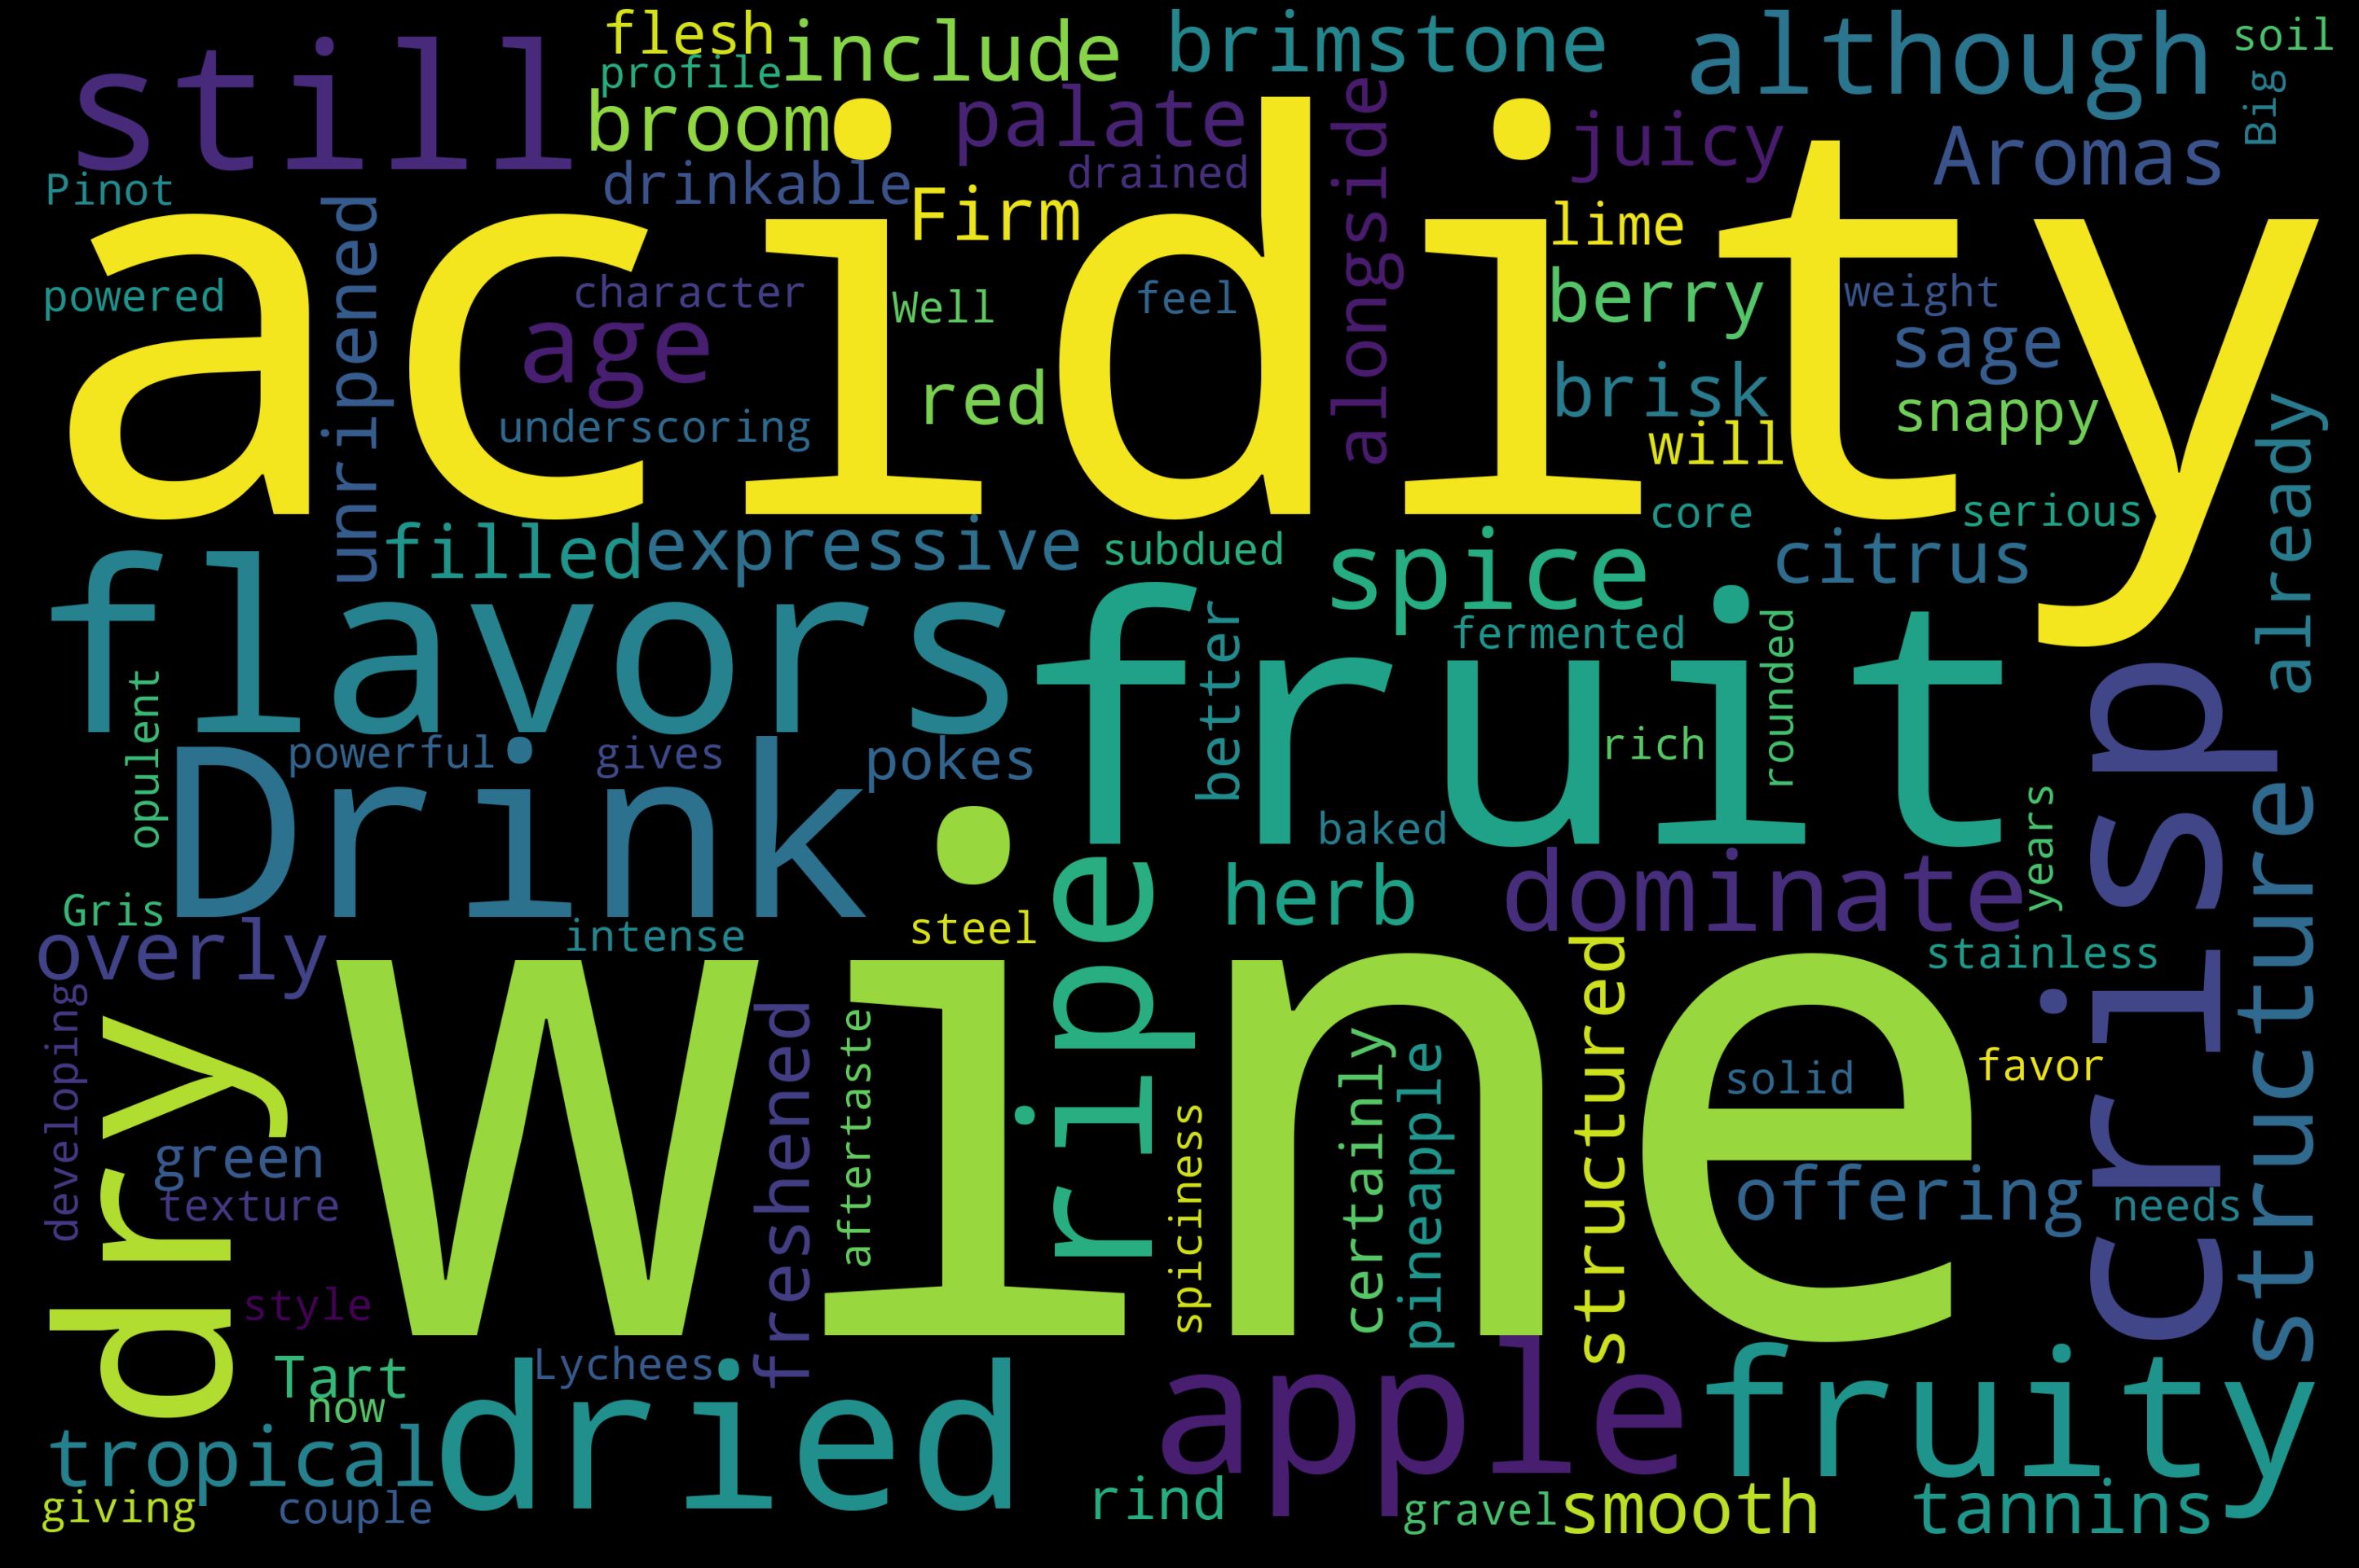

In [3]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = df.description.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Create Calculated Columns for Labels
This is going to be multi-classification for the price points or grape variety of the wines reviewed by the wine critics. Right now our points and price are number features. This needs to be updated to a text feature category, to do this we will create a couple functions to generate calculated columns based on the values in the points and price columns to use as are our labels.

Create quality column from points values to classes of bad, ok, good, and great. Below is a function to return string quality based on the points value.


### 1. Create quality column from points values to classes of bad, ok, good, and great. Below is a function to return string quality based on the points value.

In [4]:
#Function to return string quality based on points value.
def getQuality(points):
    if(points <= 80):
        return 'bad'
    elif(points<=90 ):
        return 'ok'
    elif(points<=95):
        return 'good'
    elif(points<=100):
        return 'great'
    else:
        return 'If this gets hit, we did something wrong!'

### 2. Next lets apply the function to the points column of the dataframe and add a new column named `quality`.

In [5]:
df['quality'] = df['points'].apply(getQuality)

### 3. Lets visualize our new column against the price column like we did above.

C:\Users\casiljan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


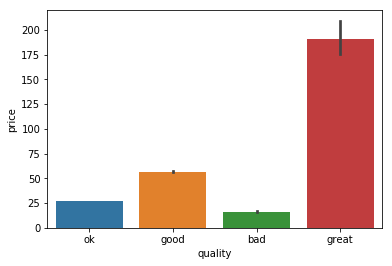

In [6]:
sns.barplot(x = 'quality', y = 'price', data = df)

### 1. Create priceRange column from price column of `1-30`, `31-50`, `51-100`, `Above 100` and `0` for columns with NaN. Below is a function to return string priceRange based on price value.

In [7]:
def getPriceRange(price):
    if(price <= 30):
        return '1-30'
    elif(price<=50):
        return '31-50'
    elif(price<=100): 
        return '51-100'
    elif(math.isnan(price)):
        return '0'
    else:
        return 'Above 100'

### 2. Apply the function to the points column of the dataframe and add a new column named `priceRange`.

In [8]:
df['priceRange'] = df['price'].apply(getPriceRange)

### 3. Print totals for each priceRange assigned to see how the labels are distributed

In [9]:
df.groupby(df['priceRange']).size()

priceRange
0             8996
1-30         73455
31-50        27746
51-100       16408
Above 100     3366
dtype: int64

We now have our labels for  models to predict quality, priceRange and grape variety.

## Process description text with the library SciKit Learn to create a Bag-of-Words using the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) functionality.

The docs do a great job of explaining the CountVectorizer. I recommend reading through them to get a full understanding of whats going on, however I will go over some of the basics here.

At a high level the CountVectorizer is taking the text of the description, removing stop words (such as “the”, “a”, “an”, “in”), creating a tokenization of the words and then creating a vector of numbers that represents the description. The text description is now represented as numbers with only the words we care about and can be processed by the computer to train a model. Remember the computer understand numbers and words can be represented as numbers so the computer can "understand".

This is an example of the words become numbers. We will go over this in more detail with an example from the dataset as well.

![graph](https://raw.githubusercontent.com/cassieview/intro-nlp-wine-reviews/master/imgs/vectorchart.PNG)


Before we jump into the CountVectorizer code and functionality. I want to list out some terms and point out that CountVectorizer _does not_ do the Lemmatiization or Stemming for you.
 
* StopWords:  A stopword can be a word with meaning in a specific language. For example, in the English language, words such as "a," "and," "is," and "the" are left out of the full-text index since they are known to be useless to a search. A stopword can also be a token that does not have linguistic meaning.
* [N-Gram](https://docs.microsoft.com/en-us/dotnet/machine-learning/resources/glossary#n-gram?WT.mc_id=github-blog-casiljan): A feature extraction scheme for text data: any sequence of N words turns into a feature value.
<img src="https://raw.githubusercontent.com/cassieview/intro-nlp-wine-reviews/master/imgs/ngram.PNG" width="500" height="500"/>

* [Lemmatization](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/preprocess-text#module-overview?WT.mc_id=github-blog-casiljan): converts multiple related words to a single canonical form ("fruity", "fruitiness" and "fruits" would all become "fruit")
* Stemming: Similar to Lemmatization but a bit more aggressive and can leave words fragmented.

### Lets take a look at how to use the CountVectorizer.

These are all the properties that you can set within the CountVectorizer. Many of them are defaulted or if set override other parts of the CountVectorizer. We are going to leave most of the defaults and then play with changing some of them to get better results for our model.

CountVectorizer(input=’content’, encoding=’utf-8’, decode_error=’strict’, strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)


## Create the function to get the vector and vectorizer from the `description` feature.

1. There are different CountVectorizer configurations commented out so that we can play with different configs and see how it changes our result. Additionally this will help us look at one description and pick apart what is actually happening in the CountVectorizer. For the first run we are going to have the below config. What this is saying is that we want to convert the text to lowercase, remove the english stopwords and we only want 5 words as feature tokens.

In [10]:
#Remove any rows with NaN values.
df = df.dropna()

In [11]:
#df.groupby('variety')['variety'].nunique()

In [12]:
df['variety'] = df['variety'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

### 3. Next lets call our function and pass in the description column from the dataframe. 

This returns the `vector` and the `vectorizer`. The `vectorizer` is what we apply to our text to create the number `vector` representation of our text so that the machine learning model can learn.

In [13]:
label = df['quality'] 
#label = df['priceRange']
#label = df['variety']
#label = df['price'] 
#label = df['points']
X,y = df['description'], label

## Train the Model

### 1. Update the function so that the second vectorizer configuration is being used and call the function to update the vectorizer.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### 3. Train the model using a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) algorithm.

In [15]:

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words="english",ngram_range=(1, 3), max_features=10000)),
    ('clf', LogisticRegression(multi_class='ovr')),
])

pipeline.fit(X_train, y_train)

C:\Users\casiljan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

Lets check the accuracy!

In [16]:
accuracy = pipeline.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))

Accuracy is 0.7905314872711031


This is an ok accuracy but I am sure it can be improved! For this tutorial we are going to call it "good enough" which is a decision that needs to be made with every model you ever build!

## Test the model

When you select a candidate model it should always be tested on unseen data. If a model is [overfitted](https://en.wikipedia.org/wiki/Overfitting) to its data it will perform really will on its own data and poorly on new data. This is why its very important to test on unseen data.

In [17]:
x = np.array([df['description'].iloc[10]])
proba = pipeline.predict_proba(x)
classes = pipeline.classes_
resultdf = pd.DataFrame(data=proba, columns=classes)

In [42]:
print(f"Predicted: {pipeline.predict(x)[0]} Actual: {df['quality'].iloc[0]}")

Predicted: ok Actual: ok


In [43]:
print(f"Points Actual {[df['points'].iloc[0]]}")

Points Actual [87]


In [22]:
resultdf.T[0].sort_values(ascending=False).head()

ok       0.979521
good     0.019935
bad      0.000330
great    0.000214
Name: 0, dtype: float64

## Other things to try
1. Change the label and run again for the price bucket prediction or grape variety
2. Try to use different algorithms to see if you can get a better result
3. Add additional features to the description text to improve accuracy. There was a strong correlation between price and points. Maybe adding those would improve the accuracy score?
4. Add lemmatization to the text to improve score using the [NLTK](https://www.nltk.org/)
5. Try doing a text classification on a different dataset.

Remember: Data science is a trial and error process. Keep thinking of ways to improve the model!

# Export the Model

In [23]:
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType


In [24]:
model_onnx = convert_sklearn(pipeline,
                             "quality",
                             initial_types=[("input", StringTensorType([None, 1]))])

In [25]:
with open("pipeline_quality.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())